In [7]:
#bring your google drive in and grant colab the ability to read/write 
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [9]:
#loading in all the functions this code may use
def file_name_to_genotype(input_path=str):
    """
    This function will copy text before the first underscore in column 2 and move it to column 1
    It will also remove all puncta that have discard set to 1 (this is when FWHM > ROI width)
    :param input_path: input a string that contains the path to your input CSV file
    :return: a data frame with the above changes made
    """
    df = pd.read_csv(input_path)
    file_names = []
    for row in range(len(df)):
        file_name = df.iloc[row, 1]
        if type(file_name) == str:
            file_name_split = file_name.split("_")
            genotype = file_name_split[0]
            df.iloc[row, 0] = genotype
        if file_name not in file_names:
            file_names.append(file_name)

    #removing all data points where discard is not set to 0 (FWHM > ROI width)
    df_filt = df.loc[:, "discard"] == 0
    df = df[df_filt]
    return df


def make_a_list_of_unique_image_names(data_frame):
    """
    This function will record all unique image names from column #2 in your CSV
    :param input_path: input the data frame you want to pull unique images names from (column 2)
    :return: returns a list of all unique strings from column 2
    """
    unique_image_names_list = []
    df = data_frame
    for row in range(len(df)):
        image_name = df.iloc[row, 1]
        if type(image_name) == str:
            if image_name not in unique_image_names_list:
                unique_image_names_list.append(image_name)
    return unique_image_names_list


def average_df(data_frame, output_path, list_of_unique_names):
    """
    This function will find the average values for each unique image name
    e.g.

    A: 3
    A: 2
    A: 4
    B: 1
    B: 2
    B: 3
     goes to :
     A: 3
     B: 2
    :param data_frame: input the data frame you want to average
    :param output_path: input the path/file name you want the averaged CSV to be saved to
    :param list_of_unique_names: input a list of all unique image names
    """
    df = data_frame

    # making an empty dictionary with a key for each variable/column
    averages_dictionary = {}
    headers_list = list(df.columns)
    for header in headers_list:
        averages_dictionary[header] = []

    # Create a mini data frame from just one image name at a time (one worm)
    for image_name in list_of_unique_names:
        df_filt = df.loc[:, "image_name"] == image_name
        file_name_specific_df = df[df_filt]

        # loop through the data frame, calculating the average for each column
        for column in range(len(file_name_specific_df.columns)):
            mean = 0
            for row in range(len(file_name_specific_df)):
                cell_value = file_name_specific_df.iloc[row, column]

                # taking all numbers and turning them into floats to add them to an average
                if isinstance(cell_value, float):
                    mean += cell_value/len(file_name_specific_df)
                if isinstance(cell_value, np.int64):
                    cell_value = float(cell_value)
                    mean += cell_value / len(file_name_specific_df)
                if isinstance(cell_value, int):
                    cell_value = float(cell_value)
                    mean += cell_value / len(file_name_specific_df)

                # if there is a string, just record the string in place of an average
                if isinstance(cell_value, str):
                    mean = cell_value

            averages_dictionary[headers_list[column]].append(mean)
    full_averages_df = pd.DataFrame(averages_dictionary)
    full_averages_df.to_csv(output_path, index=False)


def make_bar_graph(input_path=str, X=str, Y_variables=list):
    """
    this will make a bargraph with SEM bars for the CSV path you input
    :param input_path: input the path to the CSV you want to graph
    :param X: Choose the parameter for the x value (e.g. genotype)
    :param Y_variables: Input a LIST of parameters you want for the Y axis (e.g. FWHM of the puncta)
    """
    df = pd.read_csv(input_path)

    for Y_variable in Y_variables:
        # dictonary to store the data we need for a bar graph
        bar_graph_dict = {}

        # make a list of unique genotypes so we can average them
        unique_genotypes = []
        for genotype in df.loc[:, "genotype"]:
            if genotype not in unique_genotypes:
                unique_genotypes.append(genotype)
        bar_graph_dict[X] = unique_genotypes

        # calculate the averages and stdevs for each genotype, and save them in a list
        averages = []
        stdevs = []
        sems = []
        for genotype in unique_genotypes:
            df_filt = df.loc[:, "genotype"] == genotype
            geno_df = df[df_filt]
            averages.append(geno_df.loc[:, Y_variable].mean())
            stdevs.append(geno_df.loc[:, Y_variable].std())
            sems.append(geno_df.loc[:, Y_variable].sem())

        bar_graph_dict[Y_variable] = averages
        bar_graph_dict[Y_variable + "Error_bars"] = sems

        bar_graph_df = pd.DataFrame(bar_graph_dict)
        print(bar_graph_df)
        plt.bar(bar_graph_df['genotype'], bar_graph_df[Y_variable], yerr=bar_graph_df[Y_variable + "Error_bars"], capsize=5)
        plt.ylabel(Y_variable)
        plt.show()


def make_a_swarm_plot(input_path=str, X=str, Y_variables=list):
    df = pd.read_csv(input_path)

    for Y_variable in Y_variables:
        sns.swarmplot(data=df, x=X, y=Y_variable, s=4)
        plt.show()




               genotype  full_width_half_max_microns  \
0               nuIs152                     0.896373   
1          nuIs152fshr1                     0.963959   
2  nuIs152fshr1EndogRes                     0.974577   

   full_width_half_max_micronsError_bars  
0                               0.049045  
1                               0.039408  
2                               0.035559  


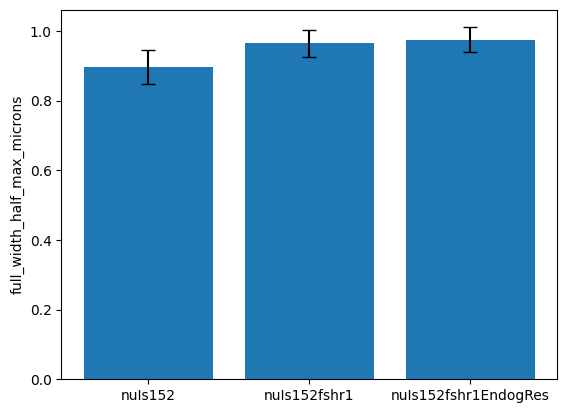

               genotype  ROI max intensity  ROI max intensityError_bars
0               nuIs152        2196.760701                   110.576216
1          nuIs152fshr1        2619.378922                   146.463170
2  nuIs152fshr1EndogRes        1810.516937                   114.388540


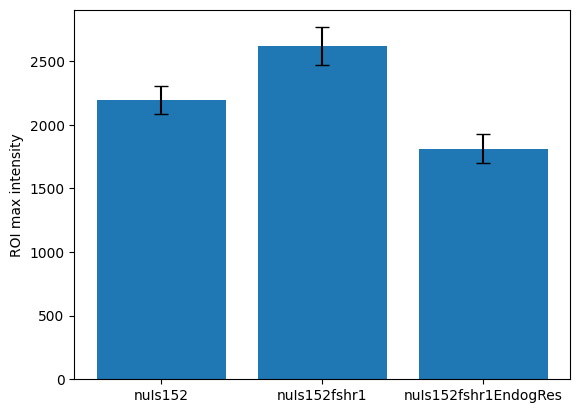

In [10]:
# path assignments
CSV_input = "/content/drive/MyDrive/Puncta_size.csv"
CSV_output = "/content/drive/MyDrive/Puncta_size_averages.csv"

# Step 1: Pull the genotype from the file name to make stats easier later
df = file_name_to_genotype(CSV_input)

# Step 2: Make a list of all unique image names in the CSV
list_file_names = make_a_list_of_unique_image_names(df)

# Step 3: Make a filtered array for each unique file name, and average the data frame for each unique file name as save as csv
average_df(df, CSV_output, list_file_names)

# Step 4 plot the data (SEM error bars)
make_bar_graph(CSV_output, "genotype", ["full_width_half_max_microns", "ROI max intensity"])

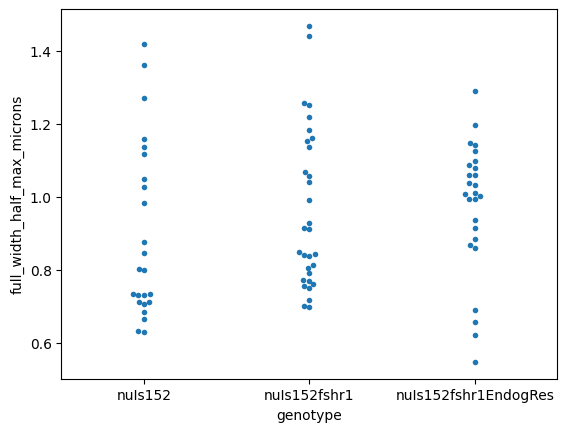

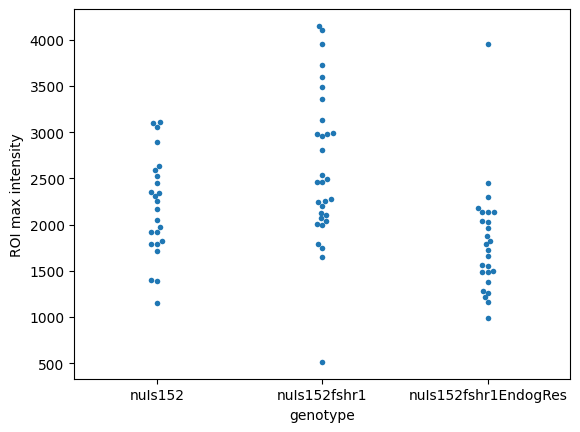

In [11]:
# Step ? plot the data (swarm plot)
make_a_swarm_plot(CSV_output, "genotype", ["full_width_half_max_microns", "ROI max intensity"])